In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer

# Add src to path just in case
sys.path.append(os.path.join(os.getcwd(), '..'))

# Set style
sns.set(style="whitegrid")


In [2]:
class EDADashboard:
    def __init__(self, df):
        self.df = df
        
        # Ensure we have column names if missing (e.g. from numpy array)
        if hasattr(self.df, "columns") and (len(self.df.columns) == 0 or isinstance(self.df.columns[0], int)):
             self.df.columns = [f"col_{i}" for i in range(self.df.shape[1])]

        self.numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        # Exclude target/label/id from numeric_cols to prevent feature engineering on them
        exclude_cols = ['label', 'target', 'id', 'class']
        self.numeric_cols = [c for c in self.numeric_cols if c.lower() not in exclude_cols]
        # Suppress future warning for object/str
        self.categorical_cols = self.df.select_dtypes(include=['object', 'category']).columns.tolist()

    def generate_summary(self):
        print("--- Data Summary ---")
        print("Head:")
        display(self.df.head())
        print("\nInfo:")
        self.df.info()
        print("\nDescription:")
        display(self.df.describe())
        print("\nMissing Values:")
        print(self.df.isnull().sum())
        
    def analyze_distributions(self):
        print("--- Distributions ---")
        if not self.numeric_cols:
            print("No numeric columns found.")
            return

        # Limit to first 5 columns to prevent flooding if thousands of features exist (like TFIDF)
        display_cols = self.numeric_cols[:5]
        if len(self.numeric_cols) > 5:
            print(f"Displaying distributions for first 5 numeric columns out of {len(self.numeric_cols)}...")

        for col in display_cols:
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            sns.histplot(self.df[col], kde=True)
            plt.title(f'Histogram of {col}')
            
            plt.subplot(1, 2, 2)
            sns.boxplot(x=self.df[col])
            plt.title(f'Boxplot of {col}')
            
            plt.show()
            
            # Use pandas skew/kurt methods safely
            try:
                s = self.df[col].skew()
                k = self.df[col].kurt()
                print(f"{col} - Skewness: {s:.2f}, Kurtosis: {k:.2f}\n")
            except:
                pass
            
    def analyze_correlations(self, threshold=0.8):
        print("--- Correlation Analysis ---")
        if len(self.numeric_cols) < 2:
            print("Not enough numerical columns for correlation analysis.")
            return

        # If too many columns, correlation matrix is too heavy. Sample or select top variance.
        if len(self.numeric_cols) > 50:
            print("To many columns for full heatmap. Selecting top 50 by variance.")
            try:
                variances = self.df[self.numeric_cols].var()
                top_cols = variances.nlargest(50).index.tolist()
                corr = self.df[top_cols].corr()
            except Exception as e:
                print(f"Could not calculate top variance: {e}. Using first 20 columns.")
                corr = self.df[self.numeric_cols[:20]].corr()
        else:
            corr = self.df[self.numeric_cols].corr()

        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, annot=False if len(corr) > 20 else True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Matrix")
        plt.show()
        
        print(f"High Correlations (> {threshold}):")
        high_corr = []
        # Get pairs
        pairs = corr.unstack()
        # Sort
        sorted_pairs = pairs.sort_values(kind="quicksort", ascending=False)
        # Filter
        strong_pairs = sorted_pairs[abs(sorted_pairs) > threshold]
        # Remove self correlations and duplicates
        strong_pairs = strong_pairs[strong_pairs < 1.0]
        # Since it's symmetric, we might get duplicates, but simple iteration is fine for EDA
        unique_pairs = []
        for index, val in strong_pairs.items():
            i, j = index
            if (j, i) not in unique_pairs and i != j:
                unique_pairs.append((i, j))
                print(f"{i} - {j}: {val:.2f}")

    def create_features(self):
        print("--- Feature Engineering ---")
        df_new = self.df.copy()
        
        # 1. Interaction Features (Example: multiply top 2 num cols if exist)
        if len(self.numeric_cols) >= 2:
            c1, c2 = self.numeric_cols[0], self.numeric_cols[1]
            new_col = f"{c1}_x_{c2}"
            df_new[new_col] = df_new[c1] * df_new[c2]
            print(f"Created interaction feature: {new_col}")
            
        # 2. Polynomial Features (Squared)
        for col in self.numeric_cols[:2]: # Limit to first 2 to avoid explosion
            new_col = f"{col}_squared"
            df_new[new_col] = df_new[col] ** 2
            print(f"Created polynomial feature: {new_col}")
            
        # 3. Binning
        for col in self.numeric_cols[:2]: # Limit to first 2
            try:
                est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
                new_col = f"{col}_binned"
                # Reshape for sklearn
                data_reshaped = df_new[col].values.reshape(-1, 1)
                df_new[new_col] = est.fit_transform(data_reshaped).flatten()
                print(f"Created binned feature: {new_col}")
            except Exception as e:
                print(f"Skipping binning for {col}: {e}")
                
        return df_new


In [3]:
# Load Data
try:
    print("Attempting to load cleaned_data.csv for meaningful EDA...")
    file_path = r"c:\project\fake_news_detection_media_integrity\data\processed\cleaned_data.csv"
    
    if os.path.exists(file_path):
        print(f"Loading data from {file_path}...")
        df = pd.read_csv(file_path)
        print(f"Data loaded. Shape: {df.shape}")
        
        # FEATURE EXTRACTION FOR EDA SUITABILITY
        # Since the csv has mostly text, we need to create numerical features 
        # so that histograms and correlations actually show something interesting.
        print("Extracting basic text features for EDA purposes...")
        
        if 'clean_text' in df.columns:
            target_col = 'clean_text'
        elif 'text' in df.columns:
            target_col = 'text'
        else:
            target_col = None
            
        if target_col:
            # Ensure string type and handle NaNs
            df[target_col] = df[target_col].astype(str).fillna('')
            # Ensure string type
            
            df['word_count'] = df[target_col].apply(lambda x: len(str(x).split()))
            df['char_count'] = df[target_col].apply(lambda x: len(str(x)))
            df['avg_word_length'] = df['char_count'] / (df['word_count'] + 1)
            
            print("Added numerical features: word_count, char_count, avg_word_length")
        else:
            print("No text column found to extract features from.")
        
    else:
        print("cleaned_data.csv not found. Checking for X_train.pkl...")
        pkl_path = r"c:\project\fake_news_detection_media_integrity\data\processed\X_train.pkl"
        
        if os.path.exists(pkl_path):
             df_raw = pd.read_pickle(pkl_path)
             if hasattr(df_raw, "toarray"):
                  print("Loaded X_train.pkl (Sparse Matrix). Sampling 1000 rows for EDA...")
                  df_raw = df_raw[:1000]
                  df = pd.DataFrame(df_raw.toarray())
                  df.columns = [f"tfidf_{i}" for i in range(df.shape[1])]
             else:
                  df = df_raw
        else:
             raise FileNotFoundError("No processed data found.")

except Exception as e:
    print(f"CRITICAL ERROR: {e}")
    raise e


Attempting to load cleaned_data.csv for meaningful EDA...
Loading data from c:\project\fake_news_detection_media_integrity\data\processed\cleaned_data.csv...
Data loaded. Shape: (64236, 4)
Extracting basic text features for EDA purposes...
Added numerical features: word_count, char_count, avg_word_length


--- Data Summary ---
Head:


,text,label,source,clean_text,word_count,char_count,avg_word_length
0,"WHO praises India's Aarogya Setu app, says it ...",1.0,IFND,praise india aarogya setu app say helped ident...,10,66,6.000000
1,"In Delhi, Deputy US Secretary of State Stephen...",1.0,IFND,delhi deputy u secretary state stephen biegun ...,10,68,6.181818
2,LAC tensions: China's strategy behind delibera...,1.0,IFND,lac tension china strategy behind deliberately...,9,65,6.500000
3,India has signed 250 documents on Space cooper...,1.0,IFND,india signed document space cooperation countr...,8,58,6.444444
4,Tamil Nadu chief minister's mother passes away...,1.0,IFND,tamil nadu chief minister mother pass away,7,42,5.250000



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64236 entries, 0 to 64235
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             64235 non-null  object 
 1   label            64236 non-null  float64
 2   source           64236 non-null  object 
 3   clean_text       64236 non-null  object 
 4   word_count       64236 non-null  int64  
 5   char_count       64236 non-null  int64  
 6   avg_word_length  64236 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 3.4+ MB

Description:


,label,word_count,char_count,avg_word_length
count,64236.000000,64236.000000,64236.000000,64236.000000
mean,0.822981,23.704527,166.011178,6.377393
std,0.381688,52.550987,372.374223,0.750464
min,0.000000,1.000000,3.000000,1.500000
25%,1.000000,9.000000,59.000000,5.888889
50%,1.000000,11.000000,76.000000,6.411765
75%,1.000000,18.000000,130.000000,6.888889
max,1.000000,1456.000000,10664.000000,12.882353



Missing Values:
text               1
label              0
source             0
clean_text         0
word_count         0
char_count         0
avg_word_length    0
dtype: int64
--- Distributions ---


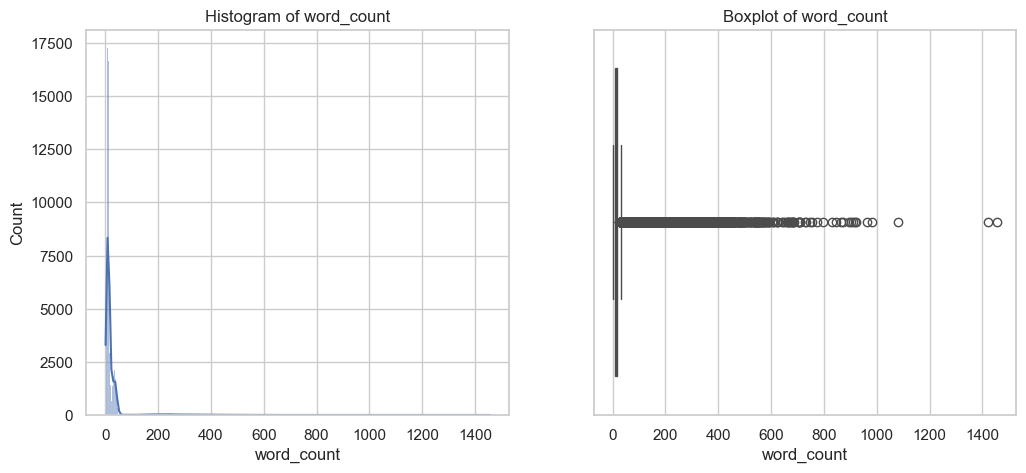

word_count - Skewness: 7.23, Kurtosis: 73.77



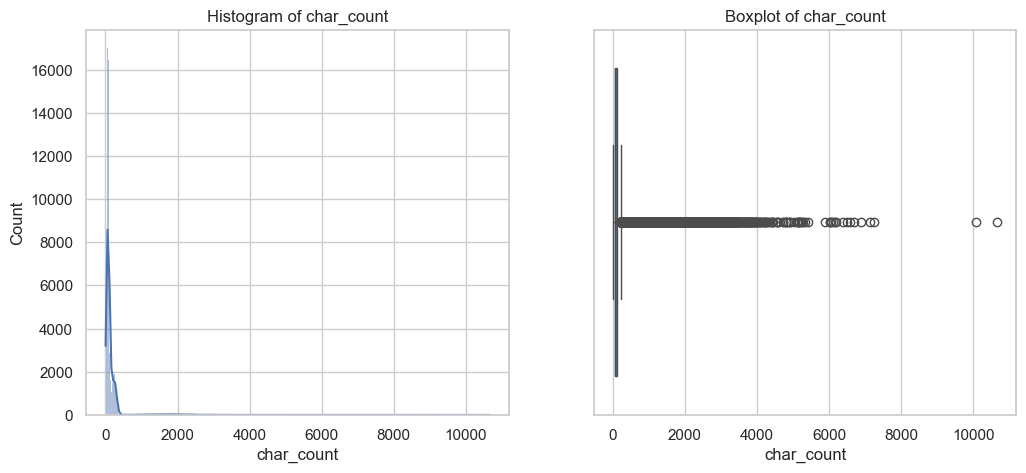

char_count - Skewness: 7.28, Kurtosis: 75.80



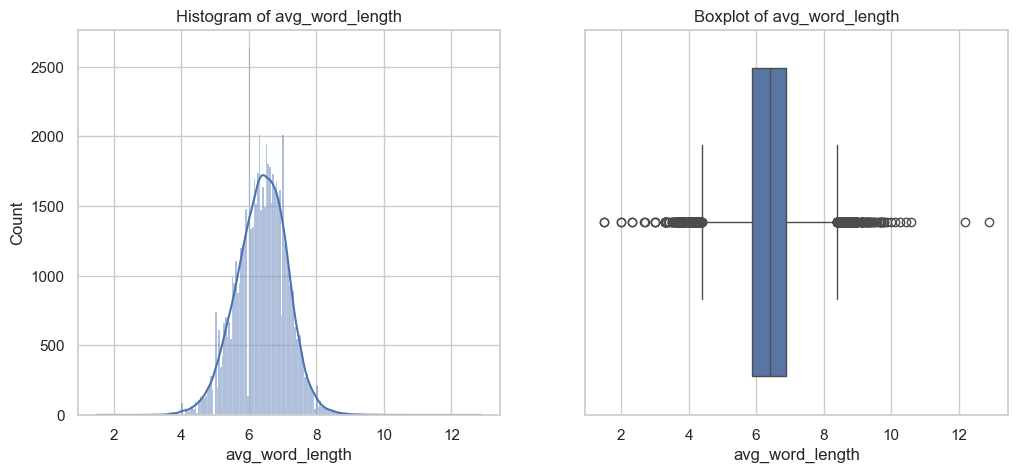

avg_word_length - Skewness: -0.17, Kurtosis: 0.59

--- Correlation Analysis ---


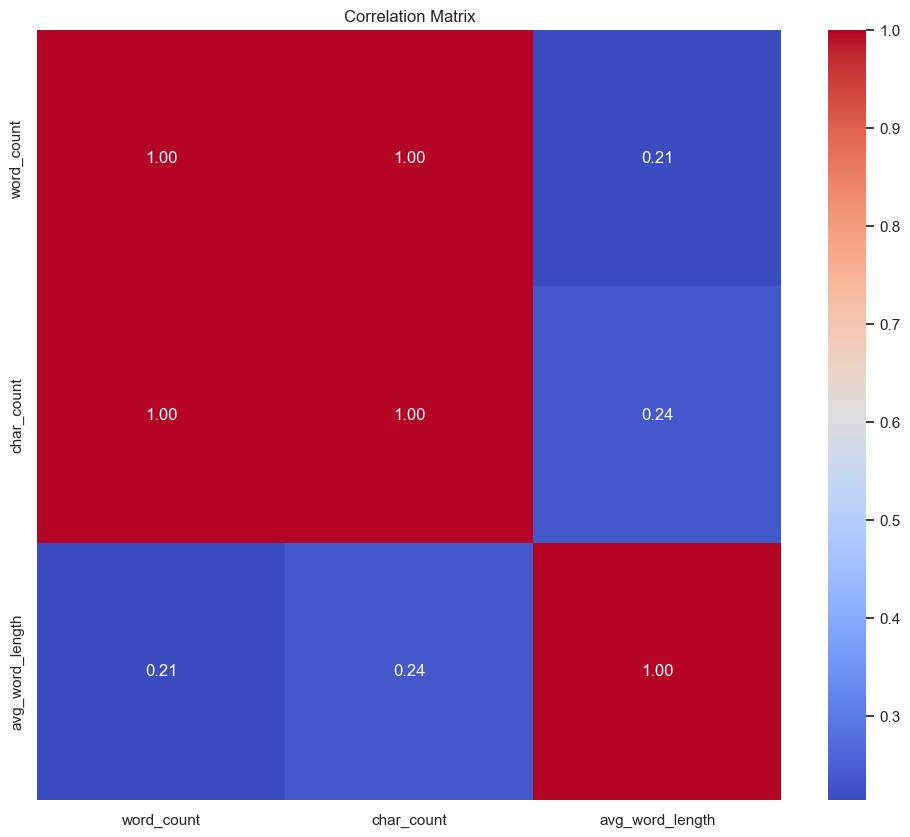

High Correlations (> 0.8):
char_count - word_count: 1.00
--- Feature Engineering ---
Created interaction feature: word_count_x_char_count
Created polynomial feature: word_count_squared
Created polynomial feature: char_count_squared
Created binned feature: word_count_binned
Created binned feature: char_count_binned

First 5 rows of improved dataframe:


,text,label,source,clean_text,word_count,char_count,avg_word_length,word_count_x_char_count,word_count_squared,char_count_squared,word_count_binned,char_count_binned
0,"WHO praises India's Aarogya Setu app, says it ...",1.0,IFND,praise india aarogya setu app say helped ident...,10,66,6.000000,660,100,4356,2.0,1.0
1,"In Delhi, Deputy US Secretary of State Stephen...",1.0,IFND,delhi deputy u secretary state stephen biegun ...,10,68,6.181818,680,100,4624,2.0,1.0
2,LAC tensions: China's strategy behind delibera...,1.0,IFND,lac tension china strategy behind deliberately...,9,65,6.500000,585,81,4225,1.0,1.0
3,India has signed 250 documents on Space cooper...,1.0,IFND,india signed document space cooperation countr...,8,58,6.444444,464,64,3364,1.0,1.0
4,Tamil Nadu chief minister's mother passes away...,1.0,IFND,tamil nadu chief minister mother pass away,7,42,5.250000,294,49,1764,0.0,0.0


In [4]:
# Run Dashboard
dashboard = EDADashboard(df)

# 1. Summary
dashboard.generate_summary()

# 2. Distributions
dashboard.analyze_distributions()

# 3. Correlations
dashboard.analyze_correlations()

# 4. Feature Engineering
df_enhanced = dashboard.create_features()

print("\nFirst 5 rows of improved dataframe:")
display(df_enhanced.head())
